## Clustering asthma-related papers in CORD-19 dataset

### Introduction
The goal of this project is to explore research topics in asthma and coronviruses. What are the most popular topics the research community is focused on, before and after the COVID-19 outbreak? Are the areas of interest around asthma and coronaviruses the same before and after the appearance of SARS-CoV-2? 

In this project, I use Natural Language Processing (NLP) techniques in Python, to explore topics of research between asthma and coronaviruses before the identification of SARS-CoV-2, but also after the outbreak of the pandemic. The analysis is based on clustering scientific publications, in order to create groups of papers with similar topics. Two groups of clusters are created, one for papers published before and one for papers published after the COVID-19 outbreak. For the two periods of times, clustering aims at identifying popular research topics and finding potential gaps in research between asthma and the new coronavirus.

More details about the motivation and the scientific background of this data analysis can be found in my Medium article:


### Data
In response to the COVID-19 pandemic a large database, the COVID-19 Open Research Dataset (CORD-19), was created and has been made publicly available. CORD-19 is a resource of hundreds of thousands scholarly articles, about COVID-19, SARS-CoV-2, and related coronaviruses: https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

### Collecting and Preprocessing Data

From this large database, I kept only those papers where the word "asthma" appears at least once in the abstract.

I went through the following text preprocessing steps, using NLTK and SpaCy:
- Removal of stop words
- Removal of non-English publications

Using their publication date, I divided the papers into those published before the outbreak of the pandemic (December 2019) and those published after. For the two groups of papers I applied:
- Tokenization
- Stemming
- Use of the Scikit-learn's Tfidf Vectorizer to transform tokens into a matrix of TF-IDF features
- Application of the KMeans algorithm for Clustering
- Application of the PCA algorithm for dimensionality reduction and clusters' visualization

*Note: This data analysis was performed in February 2021 and doesn't take into account potential databases updates.*


### Loading libraries

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

In [2]:
pd.options.display.max_colwidth = 200

In [3]:
import nltk
import string
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from langdetect import detect

In [4]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

In [5]:
import pickle

In [6]:
import plotly.express as px
import plotly.io as pio
pio.renderers
import plotly.graph_objects as go

import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

In [7]:
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

In [8]:
spacy_stop_words = ['whence', 'here', 'show', 'were', 'why', 'n’t', 'the', 'whereupon', 'not', 'more', 'how', 'eight', 'indeed', 'i', 'only', 'via', 'nine', 're', 'themselves', 'almost', 'to', 'already', 'front', 'least', 'becomes', 'thereby', 'doing', 'her', 'together', 'be', 'often', 'then', 'quite', 'less', 'many', 'they', 'ourselves', 'take', 'its', 'yours', 'each', 'would', 'may', 'namely', 'do', 'whose', 'whether', 'side', 'both', 'what', 'between', 'toward', 'our', 'whereby', "'m", 'formerly', 'myself', 'had', 'really', 'call', 'keep', "'re", 'hereupon', 'can', 'their', 'eleven', '’m', 'even', 'around', 'twenty', 'mostly', 'did', 'at', 'an', 'seems', 'serious', 'against', "n't", 'except', 'has', 'five', 'he', 'last', '‘ve', 'because', 'we', 'himself', 'yet', 'something', 'somehow', '‘m', 'towards', 'his', 'six', 'anywhere', 'us', '‘d', 'thru', 'thus', 'which', 'everything', 'become', 'herein', 'one', 'in', 'although', 'sometime', 'give', 'cannot', 'besides', 'across', 'noone', 'ever', 'that', 'over', 'among', 'during', 'however', 'when', 'sometimes', 'still', 'seemed', 'get', "'ve", 'him', 'with', 'part', 'beyond', 'everyone', 'same', 'this', 'latterly', 'no', 'regarding', 'elsewhere', 'others', 'moreover', 'else', 'back', 'alone', 'somewhere', 'are', 'will', 'beforehand', 'ten', 'very', 'most', 'three', 'former', '’re', 'otherwise', 'several', 'also', 'whatever', 'am', 'becoming', 'beside', '’s', 'nothing', 'some', 'since', 'thence', 'anyway', 'out', 'up', 'well', 'it', 'various', 'four', 'top', '‘s', 'than', 'under', 'might', 'could', 'by', 'too', 'and', 'whom', '‘ll', 'say', 'therefore', "'s", 'other', 'throughout', 'became', 'your', 'put', 'per', "'ll", 'fifteen', 'must', 'before', 'whenever', 'anyone', 'without', 'does', 'was', 'where', 'thereafter', "'d", 'another', 'yourselves', 'n‘t', 'see', 'go', 'wherever', 'just', 'seeming', 'hence', 'full', 'whereafter', 'bottom', 'whole', 'own', 'empty', 'due', 'behind', 'while', 'onto', 'wherein', 'off', 'again', 'a', 'two', 'above', 'therein', 'sixty', 'those', 'whereas', 'using', 'latter', 'used', 'my', 'herself', 'hers', 'or', 'neither', 'forty', 'thereupon', 'now', 'after', 'yourself', 'whither', 'rather', 'once', 'from', 'until', 'anything', 'few', 'into', 'such', 'being', 'make', 'mine', 'please', 'along', 'hundred', 'should', 'below', 'third', 'unless', 'upon', 'perhaps', 'ours', 'but', 'never', 'whoever', 'fifty', 'any', 'all', 'nobody', 'there', 'have', 'anyhow', 'of', 'seem', 'down', 'is', 'every', '’ll', 'much', 'none', 'further', 'me', 'who', 'nevertheless', 'about', 'everywhere', 'name', 'enough', '’d', 'next', 'meanwhile', 'though', 'through', 'on', 'first', 'been', 'hereby', 'if', 'move', 'so', 'either', 'amongst', 'for', 'twelve', 'nor', 'she', 'always', 'these', 'as', '’ve', 'amount', '‘re', 'someone', 'afterwards', 'you', 'nowhere', 'itself', 'done', 'hereafter', 'within', 'made', 'ca', 'them']

In [9]:
# extending the list of stopwords taken into account
stop_words.extend(spacy_stop_words)

### Data overview

In [10]:
# Loading the csv file to a pandas datafram have a look at the papers' metadata:
asthma_df = pd.read_csv("asthma_data.csv")
asthma_df.head(n=3)

,gitcord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,abstract_lower,title_lower
0,qva0jt86,4ba79e54ecf81b30b56461a6aec2094eaf7b7f06,PMC,Relevance of human metapneumovirus in exacerbations of COPD,10.1186/1465-9921-6-150,PMC1334186,16371156.0,cc-by,"BACKGROUND AND METHODS: Human metapneumovirus (hMPV) is a recently discovered respiratory virus associated with bronchiolitis, pneumonia, croup and exacerbations of asthma. Since respiratory virus...",2005-12-21,...,Respir Res,NaN,NaN,NaN,document_parses/pdf_json/4ba79e54ecf81b30b56461a6aec2094eaf7b7f06.json,document_parses/pmc_json/PMC1334186.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1334186/,NaN,"background and methods: human metapneumovirus (hmpv) is a recently discovered respiratory virus associated with bronchiolitis, pneumonia, croup and exacerbations of asthma. since respiratory virus...",relevance of human metapneumovirus in exacerbations of copd
1,chz8luni,d68d71553d3a31381c0c3851351f912a9a7be1c9,PMC,Surfactant therapy for acute respiratory failure in children: a systematic review and meta-analysis,10.1186/cc5944,PMC2206432,17573963.0,cc-by,"INTRODUCTION: Exogenous surfactant is used to treat acute respiratory failure in children, although the benefits and harms in this setting are not clear. The objective of the present systematic re...",2007-06-15,...,Crit Care,NaN,NaN,NaN,document_parses/pdf_json/d68d71553d3a31381c0c3851351f912a9a7be1c9.json,document_parses/pmc_json/PMC2206432.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2206432/,NaN,"introduction: exogenous surfactant is used to treat acute respiratory failure in children, although the benefits and harms in this setting are not clear. the objective of the present systematic re...",surfactant therapy for acute respiratory failure in children: a systematic review and meta-analysis
2,3zh8jmc2,fe2000f280297c40bc53ce95d703a9ca6aac19fd,PMC,Differential Regulation of Type I Interferon and Epidermal Growth Factor Pathways by a Human Respirovirus Virulence Factor,10.1371/journal.ppat.1000587,PMC2736567,19806178.0,cc-by,"A number of paramyxoviruses are responsible for acute respiratory infections in children, elderly and immuno-compromised individuals, resulting in airway inflammation and exacerbation of chronic d...",2009-09-18,...,PLoS Pathog,NaN,NaN,NaN,document_parses/pdf_json/fe2000f280297c40bc53ce95d703a9ca6aac19fd.json,document_parses/pmc_json/PMC2736567.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2736567/,NaN,"a number of paramyxoviruses are responsible for acute respiratory infections in children, elderly and immuno-compromised individuals, resulting in airway inflammation and exacerbation of chronic d...",differential regulation of type i interferon and epidermal growth factor pathways by a human respirovirus virulence factor


There are 2567 papers containing the word "asthma", among the coronavirus-related publications 

In [11]:
asthma_df.shape

(2567, 21)

In [12]:
# Use of langdetect google library to dect the language of the "abstract" column in our dataframe

#asthma_df["lang_detect"] = asthma_df["abstract_lower"].apply(detect)

In [13]:
# As non-english papers occupy only a small percent of our total papers, they are excluded from the analysis

#asthma_df["lang_detect"].value_counts()

There are 2529 papers in total, written in english.

In [14]:
#asthma_df = asthma_df.loc[asthma_df['lang_detect'] == "en"]

In [21]:
#asthma_df.to_pickle("asthma_english.pkl")
asthma_df_en = pd.read_pickle("asthma_english.pkl")
asthma_df_en.shape

(2529, 22)

I'd like to quickly vizualize the text of these papers, that's why I create a wordcloud where the most frequent words are represented by a bigger font! I'd like to give a shape to my image and use it as a cover for my article! What would it be?

In [ ]:
virus_mask = np.array(Image.open("coronavirus_canvas.png"))

In [ ]:
text = " ".join(ab for ab in asthma_df_en["abstract_lower"].tolist())

In [ ]:
wc = WordCloud(background_color="white", max_words=100, mask=virus_mask,
               stopwords=stop_words, contour_width=3, contour_color='gray')

wc.generate(text)

wc.to_file("coronavirus_new.png")

plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Let's go back to data processing!



Papers are divided between those published before the identification of the new coronavirus, SARS-CoV-2, and those published after. I pick December 2019 as the cut-off date. 

The dataset contains 1022 papers published before December 2019 and 1507 papers published on December 2019 and later.

In [22]:
asthma_before_covid = asthma_df_en.loc[asthma_df_en['publish_time']<"2019-12-01"].reset_index(drop=True)
asthma_before_covid.shape

(1022, 22)

In [23]:
asthma_after_covid = asthma_df_en.loc[asthma_df_en['publish_time']>="2019-12-01"].reset_index(drop=True)
asthma_after_covid.shape

(1507, 22)

Let's have a look at the number of the papers published, per month, since the covid outbreak. 

In [24]:
asthma_after_covid['publish_time_new'] =  pd.to_datetime(asthma_after_covid['publish_time'])

In [25]:
asthma_after_covid['publish_month_year'] = pd.to_datetime(asthma_after_covid['publish_time']).dt.to_period('M')
asthma_after_covid.head()

,gitcord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,abstract_lower,title_lower,lang_detect,publish_time_new,publish_month_year
0,3ki0dzwb,71b8c50ee0e1f4e79e6618301b768befbf943a5d,PMC,Inflammatory and microbiological associations with near-fatal asthma requiring extracorporeal membrane oxygenation,10.1183/23120541.00267-2019,PMC6983494,32010717.0,cc-by-nc,Patients with near-fatal asthma requiring ECMO are more likely to be younger and female and are also likely to have positive viral and fungal isolates on bronchoalveolar lavage when compared to th...,2020-01-27,...,NaN,document_parses/pdf_json/71b8c50ee0e1f4e79e6618301b768befbf943a5d.json,document_parses/pmc_json/PMC6983494.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6983494/,NaN,patients with near-fatal asthma requiring ecmo are more likely to be younger and female and are also likely to have positive viral and fungal isolates on bronchoalveolar lavage when compared to th...,inflammatory and microbiological associations with near-fatal asthma requiring extracorporeal membrane oxygenation,en,2020-01-27,2020-01
1,okc7wf4n,f4edbfd3e9a8b2d0d76378e6588a5971b070a4c9,PMC,Different effects of acetyl-CoA carboxylase inhibitor TOFA on airway inflammation and airway resistance in a mice model of asthma,10.1007/s43440-019-00027-8,PMC7223088,32048254.0,no-cc,"BACKGROUND AND OBJECTIVE: Acetyl CoA carboxylase (ACC) regulates the differentiation of Th1, Th2, Th17 cells and Treg cells, which play a critical role in airway inflammation of asthma. Here we in...",2020-01-08,...,NaN,document_parses/pdf_json/f4edbfd3e9a8b2d0d76378e6588a5971b070a4c9.json,document_parses/pmc_json/PMC7223088.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7223088/,NaN,"background and objective: acetyl coa carboxylase (acc) regulates the differentiation of th1, th2, th17 cells and treg cells, which play a critical role in airway inflammation of asthma. here we in...",different effects of acetyl-coa carboxylase inhibitor tofa on airway inflammation and airway resistance in a mice model of asthma,en,2020-01-08,2020-01
2,8lqjl0ee,1f6fa8e138abc1556e853c53dcce8f5e16007fcc,PMC,Risk of Readmission and Mortality Following Hospitalization with Hypercapnic Respiratory Failure,10.1007/s00408-019-00300-w,PMC7223622,31828514.0,no-cc,PURPOSE: Hypercapnic respiratory failure (HRF) is a frequent cause of hospitalization and a common comorbidity in hospitalized patients. There are few studies addressing what factors might predict...,2019-12-11,...,NaN,document_parses/pdf_json/1f6fa8e138abc1556e853c53dcce8f5e16007fcc.json,document_parses/pmc_json/PMC7223622.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7223622/,NaN,purpose: hypercapnic respiratory failure (hrf) is a frequent cause of hospitalization and a common comorbidity in hospitalized patients. there are few studies addressing what factors might predict...,risk of readmission and mortality following hospitalization with hypercapnic respiratory failure,en,2019-12-11,2019-12
3,vosu7y6j,6fa9233f054f4bbb31972e05c1478b0ec83ccc16,PMC,Innate Type 2 Responses to Respiratory Syncytial Virus Infection,10.3390/v12050521,PMC7290766,32397226.0,cc-by,"Respiratory syncytial virus (RSV) is a common and contagious virus that results in acute respiratory tract infections in infants. In many cases, the symptoms of RSV remain mild, however, a subset ...",2020-05-08,...,NaN,document_parses/pdf_json/6fa9233f054f4bbb31972e05c1478b0ec83ccc16.json,document_parses/pmc_json/PMC7290766.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7290766/,NaN,"respiratory syncytial virus (rsv) is a common and contagious virus that results in acute respiratory tract infections in infants. in many cases, the symptoms of rsv remain mild, however, a subset ...",innate type 2 responses to respiratory syncytial virus infection,en,2020-05-08,2020-05
4,yyw64g9w,8d634bba632c08e7d8e105a66dac4e0d813ab4e9,PMC,From Mouse to

In [26]:
asthma_after_covid = asthma_after_covid.sort_values('publish_month_year')

In [27]:
dates = asthma_after_covid["publish_month_year"].value_counts()
dates_df = dates.to_frame().reset_index()

In [28]:
dates_df = dates_df.sort_values("index")

In [29]:
dates_df.rename(columns={"index": "date_published", "publish_month_year":"number of papers"})

,date_published,number of papers
12,2019-12,10
0,2020-01,601
13,2020-02,9
14,2020-03,8
11,2020-04,19
8,2020-05,69
7,2020-06,74
3,2020-07,92
9,2020-08,60
4,2020-09,90


The graph below illustrates the number of papers published through the last 12-14 months. However, we recognize that the two picks noticed in January 2020 and January 2021 are not completely accurate. As a certain number of papers had only the year (yyyy) mentioned as publication date, January 1st of that year (01/01/yyyy) is taken as their complete date.

As a result, we cannot draw a very accurate example of the distribution of publications through the months.

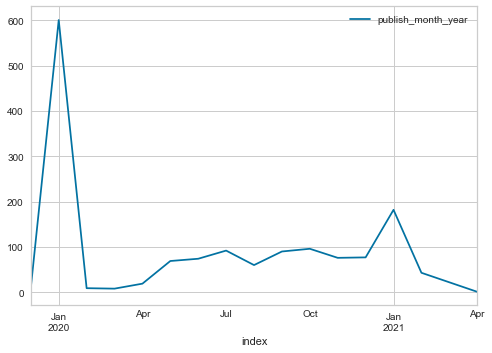

In [30]:
dates_df.plot(x ='index', y = 'publish_month_year')

## Clustering

### Before COVID-19

In [31]:
texts_before = asthma_before_covid["abstract_lower"].tolist()
len(texts_before)

1022

In [32]:
def custom_tokenizer(str_input):
    
    stemmer = PorterStemmer()
    words = nltk.word_tokenize(str_input)
    words = [word for word in words if word.lower() not in stop_words]
    
    words = [word.replace('â¡', '') for word in words]
    words = [word.replace('â¢', '') for word in words]
    words = [word.replace('â£', '') for word in words]
       
    words = [''.join(c for c in word if c not in string.punctuation+'©±×≤≥●＜--“”→„') for word in words]
    words = [word for word in words if word not in ['‘', '’', '„']]
        
    words = [word for word in words if word]
    words = [word for word in words if not any(char.isdigit() for char in word)]
    
    words = [stemmer.stem(word) for word in words]
    words = [word for word in words if len(word)> 1]
    words = [word for word in words if "asthma" not in word]
    
        
    return words

In [33]:
#vec_before = TfidfVectorizer(tokenizer=custom_tokenizer,
                             #max_features=2000,
                      #stop_words='english')

#matrix_fitted = vec_before.fit(texts_before)

In [34]:
#pickle.dump(vec_before, open("vectorizer_model_before.pkl", 'wb'))

In [35]:
vec_before = pickle.load(open("vectorizer_model_before.pkl",'rb'))

In [36]:
matrix_before = vec_before.transform(texts_before)
df_before = pd.DataFrame(matrix_before.toarray(), columns=vec_before.get_feature_names())
df_before.head()

c:\users\katerina\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cri', 'describ', 'sincer'] not in stop_words.



,aa,abdelbaset,abil,abl,abnorm,absenc,absent,absolut,abstract,abuelmagd,...,yoonseok,youn,young,younger,younghe,youngho,yr,yu,yun,zhang
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


I use the "elbow" method for an estimation of the optimal number of clusters for the group of papers:
https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

However, in the context of this analysis the results are not reproducible and different number of clusters is suggested by the model. For this reason, the method is not taken completely into account. The code for the elbow method is commented but you can run the code for a sense of how the model works.

In [37]:
#def vizualize_elbow(data, min_cluster=4, max_cluster=20):
    
    #model = KMeans(random_state=2)
    #visualizer = KElbowVisualizer(model, k=(min_cluster, max_cluster))

    #visualizer.fit(data)
       
    #return visualizer  

In [38]:
#viz_before = vizualize_elbow(matrix_before)
#viz_before.show()

Kmeans in clustering: https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1

In [39]:
number_of_clusters=11
#km_before = KMeans(n_clusters=number_of_clusters, random_state=1)
#km_before.fit(matrix_before)

In [40]:
#pickle.dump(km_before, open("model_before.pkl", "wb"))

In [41]:
km_before = pickle.load(open("model_before.pkl", "rb"))

Let's have an overview of our clusters' centers (centroids) and labels. Then we get the top 20 terms for every cluster. In other words, we see which are the most frequently mentioned words per cluster. Note that since we have applied Stemming, we only have the "root" of the words now.

In [42]:
centroids_before, labels_before = km_before.cluster_centers_, km_before.labels_
print(labels_before)

[ 4 10  5 ...  7  7  6]


In [43]:
print("Top terms per cluster:")
order_centroids_before = centroids_before.argsort()[:, ::-1]
terms = vec_before.get_feature_names()
for i in range(number_of_clusters):
    top_words = [terms[ind] for ind in order_centroids_before[i, :20]]
    print("Cluster {}: {}".format(i, ' '.join(top_words)))

Top terms per cluster:
Cluster 0: detect children respiratori patient infect virus exacerb viral rhinoviru viru sampl hospit adenoviru ill posit coronaviru clinic influenza acut pcr
Cluster 1: infect respiratori viral exacerb virus respons diseas role develop immun viru review caus tract associ host mechan human airway rhinoviru
Cluster 2: exacerb copd patient factor risk airway trigger infect increas sever viral acut sputum eosinophil diseas exposur manag allergi children virusinduc
Cluster 3: hrv hrvc children infect hrva human respiratori ill speci strain associ detect rhinovirus exacerb caus identifi virus lower group divers
Cluster 4: hmpv hbov children detect infect respiratori hospit rsv bronchiol human patient viru clinic pneumonia month pathogen metapneumoviru virus year ari
Cluster 5: cell airway express infect lung activ inflammatori protein diseas respons inflamm increas function role mice epitheli immun level gene receptor
Cluster 6: wheez children bronchiol risk recurr ag

PCA and its implementation in Python:
https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

In [44]:
T_before = preprocessing.Normalizer().fit_transform(df_before)

# Fit and transform the TFidf values to PCA
pca_model = PCA(n_components=2, random_state = 2)
pca_model.fit(T_before) 
T_before = pca_model.transform(T_before)

#Transform the centroids
centroids_before_pca = pca_model.transform(centroids_before)

In [45]:
centroids_before_df = pd.DataFrame(centroids_before_pca, columns = ['PCA_1','PCA_2'])

In [46]:
asthma_before_covid['Labels'] = km_before.labels_

In [47]:
asthma_before_covid['pca_1'] = T_before[:, 0]
asthma_before_covid['pca_2'] = T_before[:, 1]

In [48]:
asthma_before_covid = asthma_before_covid.sort_values(by = "Labels", ascending = True)

In [49]:
asthma_before_covid['Labels'] = asthma_before_covid['Labels'].astype(str)

In [50]:
asthma_before_covid['Labels'].value_counts().sort_values(ascending=True)

4      31
3      38
9      42
7      51
2      79
6      84
0      92
8     102
1     128
10    179
5     196
Name: Labels, dtype: int64

Finally, let's plot the clusters!

In [268]:
fig_clusters_before = px.scatter(asthma_before_covid, 
                 x="pca_1", 
                 y="pca_2", 
                 color="Labels",
                 hover_data=['title'])

fig_clusters_before.update_traces(marker=dict(size=11))

fig_clusters_before.show()

Having a look at the clusters, we assing labels to them so that we can easily get a sense of each cluster's topic!

In [269]:
centroids_before_titles = ["Human Rhinoviruses", 
                           "Immune response",
                           "Exacerbations ",
                           "HRV and pediatrics",
                           "Children",                           
                           "Molecular links",
                           "Bronchiolitis and wheezing",                           
                           "Environment",
                           "Therapeutic approaches",
                           "Viral pneumonia",
                           "Epidemiology and Clinical studies"]

In [270]:
centroids_before_df["centroids_labels"] = centroids_before_titles
centroids_before_df

,PCA_1,PCA_2,centroids_labels
0,0.199826,0.011691,Human Rhinoviruses
1,0.017520,0.179393,Immune response
2,-0.033218,0.022368,Exacerbations
3,0.118983,0.051839,HRV and pediatrics
4,0.189715,-0.031928,Children
5,-0.157219,0.052751,Molecular links
6,0.180513,-0.017154,Bronchiolitis and wheezing
7,-0.082395,-0.109228,Environment
8,-0.111899,-0.065748,Therapeutic approaches
9,0.090174,-0.107843,Viral pneumonia


In [271]:
annotations = []
import random

for index, row in centroids_before_df.iterrows():
    anno_dict = dict(x=row[0],
                y=row[1] + np.random.uniform(-0.181, 0.210),
                text=row[2],
                font=dict(color="black", family = '<b>Calibri<b>', size =25),
                showarrow=False,
                bgcolor="white",
                opacity=0.92)
    annotations.append(anno_dict)

In [272]:
for annotation in annotations:
    fig_clusters_before.add_annotation(annotation)

In [273]:
fig_clusters_before.add_trace(go.Scatter(
                         y=centroids_before_df["PCA_2"].tolist(),
                         x=centroids_before_df["PCA_1"].tolist(),
                         mode="markers+text",
    
                         #text=centroids_before_df["centroids_labels"],
                         #textfont=dict(color='black', family = 'Courier New, monospace'),
                         #textposition = 'top center',
    
                         marker=dict(size=14, color="white"),
                         name="Centroids"))

In [274]:
fig_clusters_before.update_layout(
    title_text='Asthma and various coronaviruses',
    title_font_size = 25,
    title_font_family = "<b>Calibri<b>",
    legend=dict(
        font=dict(
            size=25)))

In [275]:
fig_clusters_before.update_layout(
    xaxis_title = "",
    yaxis_title= "",
    autosize=False,
    width=1200,
    height=900)

Below, we also get the number of features, in our case the number of papers that each cluster contains.

In [91]:
asthma_before_covid['Labels'].value_counts().sort_values(ascending=False)

5     196
10    179
1     128
8     102
0      92
6      84
2      79
7      51
9      42
3      38
4      31
Name: Labels, dtype: int64

### After covid-19

The exact same process is followed for the groups of papers published after the SARS-CoV-2 outbreak.

In [276]:
texts_after = asthma_after_covid["abstract_lower"].tolist()

In [277]:
#vec_after = TfidfVectorizer(tokenizer=custom_tokenizer,
                             #max_features=2000,
                      #stop_words='english')

#matrix_fitted_after = vec_after.fit(texts_after)

In [278]:
#pickle.dump(vec_after, open("vectorizer_model_after.pkl", 'wb'))

In [279]:
vec_after = pickle.load(open("vectorizer_model_after.pkl",'rb'))

In [280]:
matrix_after = vec_after.transform(texts_after)
df_after = pd.DataFrame(matrix_after.toarray(), columns=vec_after.get_feature_names())
df_after.shape

c:\users\katerina\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cri', 'describ', 'sincer'] not in stop_words.



(1507, 2000)

In [281]:
#viz_after = vizualize_elbow(matrix_after)
#viz_after.show()

In [282]:
number_of_clusters=12
#km_after = KMeans(n_clusters=number_of_clusters, random_state=1)
#model_after = km_after.fit(matrix_after)

In [283]:
#pickle.dump(km_after, open("model_after.pkl", "wb"))

In [284]:
km_after = pickle.load(open("model_after.pkl", "rb"))

In [285]:
centroids_after, labels_after = km_after.cluster_centers_, km_after.labels_
print(centroids_after)

[[0.00327205 0.         0.         ... 0.01244031 0.0057722  0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.01544237 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [286]:
print("Top terms per cluster:")
order_centroids_after = km_after.cluster_centers_.argsort()[:, ::-1]
terms = vec_after.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids_after[i, :20]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: children pediatr infect hospit respiratori patient year age sever studi symptom risk diseas clinic picu bronchiol childhood rv control adult
Cluster 1: lung cell diseas immun respons inflamm function pulmonari role target infect activ respiratori protein airway inflammatori potenti effect mechan therapeut
Cluster 2: air health pollut impact depress lockdown mental peopl anxieti physic pandem diseas risk measur stress exposur level psycholog reduc condit
Cluster 3: case patient present diseas ct coronaviru symptom chest report day bilater test clinic opac respiratori fever emerg acut posit groundglass
Cluster 4: diseas sever respiratori infect coronaviru patient caus risk individu studi acut popul mortal pandem syndrom factor preval underli vitamin health
Cluster 5: patient hospit ci risk diseas comorbid age mortal sever associ outcom factor studi higher year icu clinic death admiss diabet
Cluster 6: patient diseas sever pandem infect risk allerg cortic

In [287]:
order_centroids_after

array([[ 297, 1304,  906, ...,  795,  794, 1999],
       [1042,  272,  525, ..., 1032, 1029,    0],
       [  70,  798, 1355, ..., 1096, 1098,    0],
       ...,
       [ 674,  755,  272, ..., 1242, 1243,    0],
       [1085,  300, 1848, ..., 1219, 1222,    0],
       [1980, 1388, 1072, ..., 1203, 1205,    0]], dtype=int64)

In [288]:
T_after = preprocessing.Normalizer().fit_transform(df_after)

# Dimesionality reduction to 2
pca_model = PCA(n_components=2, random_state=2)
pca_model.fit(T_after) 
T_after = pca_model.transform(T_after) 

#Transform the cluster's centroids
centroids_after_pca = pca_model.transform(centroids_after)

In [289]:
asthma_after_covid['Labels'] = km_after.labels_
asthma_after_covid['pca_1'] = T_after[:, 0]
asthma_after_covid['pca_2'] = T_after[:, 1]

In [290]:
centroids_after_df = pd.DataFrame(centroids_after_pca, columns = ['PCA_1','PCA_2'])
centroids_after_df

,PCA_1,PCA_2
0,0.039878,-0.191879
1,-0.162369,0.065726
2,-0.047269,-0.048443
3,0.027748,-0.048553
4,-0.039304,0.026734
5,0.193699,0.066524
6,-0.005130,0.018995
7,-0.016089,-0.092262
8,-0.059294,-0.039505
9,-0.152520,0.221299


In [291]:
asthma_after_covid = asthma_after_covid.sort_values(by = "Labels", ascending = True)

In [292]:
asthma_after_covid['Labels'] = asthma_after_covid['Labels'].astype(str)

In [302]:
fig_clusters_after = px.scatter(asthma_after_covid, 
                 x="pca_1", 
                 y="pca_2", 
                 color="Labels",
                 hover_data=['title'])

fig_clusters_after.update_traces(marker=dict(size=11))


fig_clusters_after.show()

In [303]:
centroids_after_titles = ["Pediatric asthma",
                          "",
                          "Environment and psychology",
                          "",
                          "",
                          "Severe COVID-19 infection",
                          "Various relationships",
                          "",
                          "Therapeutic approaches",
                          "Molecular links",
                          "Herbal medicines",
                          "Women and pregnancy"]

In [304]:
centroids_after_df["centroids_labels"] = centroids_after_titles
centroids_after_df

,PCA_1,PCA_2,centroids_labels
0,0.039878,-0.191879,Pediatric asthma
1,-0.162369,0.065726,
2,-0.047269,-0.048443,Environment and psychology
3,0.027748,-0.048553,
4,-0.039304,0.026734,
5,0.193699,0.066524,Severe COVID-19 infection
6,-0.005130,0.018995,Various relationships
7,-0.016089,-0.092262,
8,-0.059294,-0.039505,Therapeutic approaches
9,-0.152520,0.221299,Molecular links


In [305]:
annotations_after = []

for index, row in centroids_after_df.iterrows():
    anno_dict = dict(x=row[0],
                y=row[1] + np.random.uniform(-0.28, 0.27),
                text=row[2],
                font=dict(color="black", family = '<b>Calibri<b>', size =23),
                showarrow=False,
                bgcolor="white",
                opacity=0.95)
    annotations_after.append(anno_dict)

In [306]:
for annotation in annotations_after:
    fig_clusters_after.add_annotation(annotation)

In [307]:
fig_clusters_after.add_trace(go.Scatter(
                         y=centroids_after_df["PCA_2"].tolist(),
                         x=centroids_after_df["PCA_1"].tolist(),
                         mode="markers+text",
    
                         #text=centroids_before_df["centroids_labels"],
                         #textfont=dict(color='black', family = 'Courier New, monospace'),
                         #textposition = 'top center',
    
                         marker=dict(size=14, color="white"),
                         name="Centroids"))

In [308]:
fig_clusters_after.update_layout(
    title_text='Asthma and SARS-CoV-2',
    title_font_size = 25,
    title_font_family = "<b>Calibri<b>",
    legend=dict(
        font=dict(
            size=25)))

In [309]:
fig_clusters_after.update_layout(
    xaxis_title = "",
    yaxis_title= "",
    autosize=False,
    width=1500,
    height=1100)

In [ ]:
asthma_after_covid['Labels'].value_counts().sort_values(ascending=False)